In [1]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

from torchsummary import summary

from utils.data_utils import *
from model.encoder import Encoder
from model.generator import Generator
from model.discriminator import Discrimator

import matplotlib.pyplot as plt

In [2]:
def weight_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv3d') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)

# Args

In [3]:
choose_cuda = True
data_dir = '/home/ewok261/Documents/psychic-gan/data/in_2_out_1_ol_0'
frm_in = 2
frm_out = 1
mini_batch = 32
n_epochs = 200

In [4]:
if choose_cuda and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


# Load data

In [5]:
all_data = KITTIData(frm_in, frm_out, 0, data_dir)
[train_data,val_data] = data.random_split(all_data, [1100, 243])
[train_data, _] = data.random_split(train_data, [10, 1090]) # take a small subset of training data (for overfitting)
[val_data, _] = data.random_split(val_data, [30, 213])
train_loader = data.DataLoader(train_data, batch_size = 4, shuffle=True, num_workers=1)
val_loader = data.DataLoader(val_data, batch_size = 1, shuffle = False, num_workers = 1)
print('Train size: {0}'.format(len(train_data)))
print('Val size: {0}'.format(len(val_data)))

Train size: 10
Val size: 30


# Define the network and loss

In [6]:
loss_fun = nn.MSELoss()

encoder = Encoder(frame_dim=64, init_temp=2, hidden_dim=128, out_filters=256,
                  attention_at=8, norm=nn.utils.weight_norm, residual=True)
encoder = encoder.to(device)
encoder_optim = optim.Adam(encoder.parameters(), betas=(0.9, 0.999))

generator = Generator(frame_dim=64, temporal_target=1, hidden_dim=128,
                      init_filters=256, attention_at=32, norm=nn.utils.weight_norm)
generator = generator.to(device)
generator_optim = optim.Adam(generator.parameters(), betas=(0.9, 0.999))

encoder.apply(weight_init)
generator.apply(weight_init)

#summary(encoder, input_size=(3, frm_in, 64, 64))
#summary(generator, input_size=(128,))

Generator(
  (linear): Linear(in_features=128, out_features=4096, bias=True)
  (up_stack): ModuleList(
    (0): NormUpsample3D(
      (layer): NormUpsampleND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(256, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (upsample): Upsample(size=(1, 8, 8), mode=nearest)
        )
      )
    )
    (1): NormUpsample3D(
      (layer): NormUpsampleND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(128, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (upsample): Upsample(size=(1, 16, 16), mode=nearest)
        )
      )
    )
    (2): NormUpsample3D(
      (layer): NormUpsampleND(
        (container): ModuleDict(
          (activation): LeakyReLU(negative_slope=0.01)
          (conv): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), paddin

# Training loop

In [7]:
train_hist_real = []
train_hist_gen = []
val_hist = []
for epoch in range(n_epochs):
        running_loss_gen = 0.0
        running_loss_real = 0.0
        for i, data in enumerate(train_loader, 0):
            # get the inputs and move them to device
            in_frames, out_frames = data
            in_frames = in_frames.to(device)
            out_frames = out_frames.to(device)
            
            # zero the parameter gradients
            encoder.zero_grad()
            generator.zero_grad()
            
            # GENERATOR/ENCODER TRAINING
            hidden, encoder_attn = encoder(in_frames)
            generated, generator_attn = generator(hidden)
            
            loss_gen = loss_fun(generated, out_frames)
            
            loss_gen.backward()
            encoder_optim.step()
            generator_optim.step()

            # print statistics
            running_loss_gen += loss_gen.item() / 3
            if i % 3 == 2:
                print('[Epoch {0} - Step {1}] R-loss: {2} G-loss: {3}'.format(epoch, i, running_loss_real, running_loss_gen))
                train_hist_real.append(running_loss_real)
                train_hist_gen.append(running_loss_gen)
                running_loss_real = 0
                running_loss_gen = 0

        val_loss = 0.0
        for in_frames, out_frames in val_loader:
            # get the validation inputs and outputs
            in_frames = in_frames.to(device)
            out_frames = out_frames.to(device)
            
            # forward
            with torch.no_grad():
                hidden, encoder_attn = encoder(in_frames)
                generated, generator_attn = generator(hidden)
            
            val_loss += loss_fun(generated, out_frames).item() / len(val_loader)
            #val_loss += loss_fun(generated, out_frames).item() / len(val_loader)

        print('[Epoch {0}] Val-Loss: {1}'.format(epoch, val_loss))
        val_hist.append(val_loss)

[Epoch 0 - Step 2] R-loss: 0.0 G-loss: 0.19972676038742068
[Epoch 0] Val-Loss: 0.17760695790251096
[Epoch 1 - Step 2] R-loss: 0.0 G-loss: 0.15630772709846497
[Epoch 1] Val-Loss: 0.1429853250583013
[Epoch 2 - Step 2] R-loss: 0.0 G-loss: 0.1054305781920751
[Epoch 2] Val-Loss: 0.1481601446866989
[Epoch 3 - Step 2] R-loss: 0.0 G-loss: 0.10200764735539755
[Epoch 3] Val-Loss: 0.09821871829529602
[Epoch 4 - Step 2] R-loss: 0.0 G-loss: 0.09022067735592523
[Epoch 4] Val-Loss: 0.09519330287973089
[Epoch 5 - Step 2] R-loss: 0.0 G-loss: 0.08672029028336208
[Epoch 5] Val-Loss: 0.08846364021301269
[Epoch 6 - Step 2] R-loss: 0.0 G-loss: 0.07885108143091202
[Epoch 6] Val-Loss: 0.10014022029936313
[Epoch 7 - Step 2] R-loss: 0.0 G-loss: 0.0804461178680261
[Epoch 7] Val-Loss: 0.08946911121408144
[Epoch 8 - Step 2] R-loss: 0.0 G-loss: 0.0823359986146291
[Epoch 8] Val-Loss: 0.09027257201572257
[Epoch 9 - Step 2] R-loss: 0.0 G-loss: 0.07730100055535635
[Epoch 9] Val-Loss: 0.08855268619954586
[Epoch 10 - Ste

[Epoch 81 - Step 2] R-loss: 0.0 G-loss: 0.02282268988589446
[Epoch 81] Val-Loss: 0.05220110261191924
[Epoch 82 - Step 2] R-loss: 0.0 G-loss: 0.022677525877952576
[Epoch 82] Val-Loss: 0.05151367460687955
[Epoch 83 - Step 2] R-loss: 0.0 G-loss: 0.02215327074130376
[Epoch 83] Val-Loss: 0.052756778212885054
[Epoch 84 - Step 2] R-loss: 0.0 G-loss: 0.02392596316834291
[Epoch 84] Val-Loss: 0.0518341197942694
[Epoch 85 - Step 2] R-loss: 0.0 G-loss: 0.023965029045939445
[Epoch 85] Val-Loss: 0.05100910055140654
[Epoch 86 - Step 2] R-loss: 0.0 G-loss: 0.022753562157352764
[Epoch 86] Val-Loss: 0.05143783173213403
[Epoch 87 - Step 2] R-loss: 0.0 G-loss: 0.022867778316140175
[Epoch 87] Val-Loss: 0.050297991186380384
[Epoch 88 - Step 2] R-loss: 0.0 G-loss: 0.022002121433615685
[Epoch 88] Val-Loss: 0.0508382302398483
[Epoch 89 - Step 2] R-loss: 0.0 G-loss: 0.023673102259635925
[Epoch 89] Val-Loss: 0.05106661400447289
[Epoch 90 - Step 2] R-loss: 0.0 G-loss: 0.022311380753914516
[Epoch 90] Val-Loss: 0.0

[Epoch 160] Val-Loss: 0.05693234130740166
[Epoch 161 - Step 2] R-loss: 0.0 G-loss: 0.016107657303412754
[Epoch 161] Val-Loss: 0.05411695533742507
[Epoch 162 - Step 2] R-loss: 0.0 G-loss: 0.015354476869106293
[Epoch 162] Val-Loss: 0.05514576416462659
[Epoch 163 - Step 2] R-loss: 0.0 G-loss: 0.014225293571750324
[Epoch 163] Val-Loss: 0.05568141682694355
[Epoch 164 - Step 2] R-loss: 0.0 G-loss: 0.014872802421450615
[Epoch 164] Val-Loss: 0.054427002370357525
[Epoch 165 - Step 2] R-loss: 0.0 G-loss: 0.015340449598928291
[Epoch 165] Val-Loss: 0.057406140988071765
[Epoch 166 - Step 2] R-loss: 0.0 G-loss: 0.015553912768761316
[Epoch 166] Val-Loss: 0.05664075824121636
[Epoch 167 - Step 2] R-loss: 0.0 G-loss: 0.01684439337501923
[Epoch 167] Val-Loss: 0.05429617601136365
[Epoch 168 - Step 2] R-loss: 0.0 G-loss: 0.016472375951707363
[Epoch 168] Val-Loss: 0.05855052756766479
[Epoch 169 - Step 2] R-loss: 0.0 G-loss: 0.016106384185453255
[Epoch 169] Val-Loss: 0.05630115854243438
[Epoch 170 - Step 2] 

# Results visualization

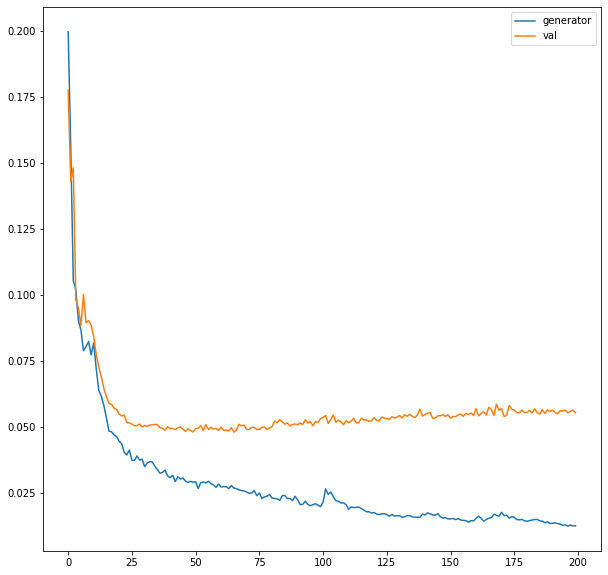

In [8]:
plt.figure(figsize=(10, 10))
plt.plot(train_hist_gen)
plt.plot(val_hist)
plt.legend(['generator', 'val'])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 2, 64, 64])
torch.Size([1, 3, 1, 64, 64])


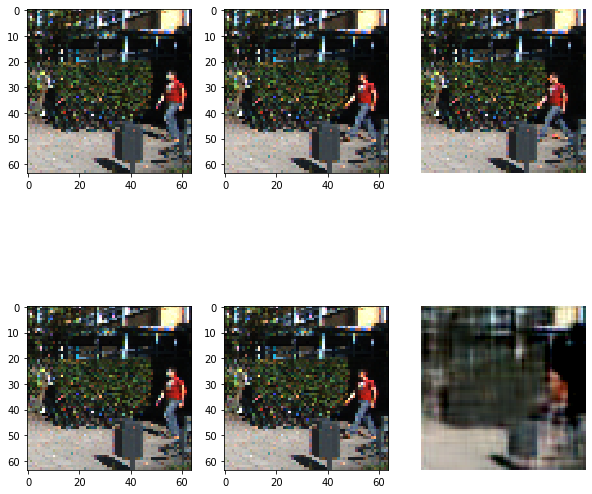

In [9]:
insamp, outsamp = train_data[0]
insamp = insamp.unsqueeze(0)
outsamp = outsamp.unsqueeze(0)
print(insamp.shape)
print(outsamp.shape)
insamp, outsamp = insamp.to(device), outsamp.to(device)

with torch.no_grad():
    hidval, encval_attn = encoder(insamp)
    genval, genval_attn = generator(hidval)

insamp = insamp.cpu().squeeze().permute(1,2,3,0).numpy()
genval = genval.cpu().squeeze().permute(1,2,0).detach().numpy()
outsamp = outsamp.cpu().squeeze().permute(1,2,0).numpy()

plt.figure(figsize=(10, 10))
# img
plt.subplot(2, frm_in+frm_out, 1)
plt.imshow(insamp[0])
plt.subplot(2, frm_in+frm_out, 2)
plt.imshow(insamp[1])
plt.subplot(2, frm_in+frm_out, 3)
plt.imshow(outsamp)
plt.axis('off')

# target
plt.subplot(2, frm_in+frm_out, 4)
plt.imshow(insamp[0])
plt.subplot(2, frm_in+frm_out, 5)
plt.imshow(insamp[1])
plt.subplot(2, frm_in+frm_out, 6)
plt.imshow(genval)
plt.axis('off')
plt.show()

In [10]:
encval_attn = encval_attn.cpu().squeeze().detach().numpy()
genval_attn = genval_attn.cpu().squeeze().detach().numpy()
print(encval_attn.shape)
print(genval_attn.shape)

(8, 8, 8, 8)
(32, 32, 32, 32)


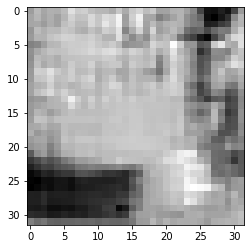

In [16]:
plt.imshow(genval_attn[16,16,:,:], cmap = 'gray')
plt.show()